# Tour of SciPy

SciPy is a collection of related sub-packages covering different scientific
routines. The scope is similar to that of the "Numerical Recipes" series of
books, but it also includes additional routines and tools (such as F2Py for
integrating Python with C and Fortran code).

Preliminary imports:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-colorblind')
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'nearest'
import numpy as np

SciPy imports:

In [2]:
# These modules and more are available in SciPy:
import scipy.stats
import scipy.optimize
import scipy.interpolate
import scipy.ndimage
import scipy.sparse
import scipy.linalg
import scipy.fftpack
import scipy.signal
# ...
# They must be imported explicitly. For speed reasons, importing ``scipy`` alone
# does not automatically import its submodules.

## Curve fitting

`scipy.optimize` enables quickly fitting parametric functions to data. Let's
give that a go.

First, load up data from your data folder. This is temperature data from Darwin
airport dating back to 1941 (!), obtained from the Bureau of Meteorology.

In [3]:
import pandas as pd

dwtemp_df = pd.read_csv('data/darwin-temp.csv', header=0, na_values='null')
dwtemp_df.head()

,Product code,Bureau of Meteorology station number,Year,Month,Mean maximum temperature (°C),Quality
0,IDCJAC0002,14015,1941,2,31.5,Y
1,IDCJAC0002,14015,1941,3,31.3,Y
2,IDCJAC0002,14015,1941,4,32.1,Y
3,IDCJAC0002,14015,1941,5,30.9,Y
4,IDCJAC0002,14015,1941,6,28.9,Y


If we want to use base NumPy arrays, without fancy time series support, we can
make an array with fractional year values for the dates:

In [4]:
dwtemp_df['Year.5'] = dwtemp_df['Year'] + (dwtemp_df['Month'] - 0.5) / 12

Now we extract these "time" values, against which we will plot the corresponding
temperature. We can use the pandas DataFrame `values` property to grab a NumPy
array of the numeric values.

In [5]:
dwtemp = dwtemp_df[['Year.5', 'Mean maximum temperature (°C)']].values

Text(0,0.5,'Mean maximum temperature (°C)')

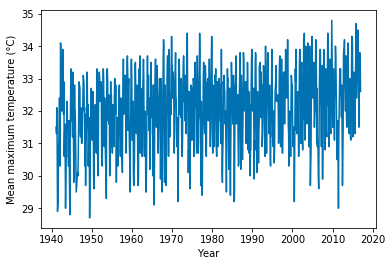

In [6]:
fig, ax = plt.subplots()

ax.plot(*dwtemp.T)
ax.set_xlabel('Year')
ax.set_ylabel('Mean maximum temperature (°C)')

You can see a "nice" increasing trend in the temperature. If we zoom in, you can
see the seasonal variations superimposed on that:

(2000, 2017)

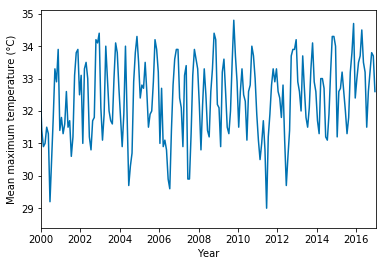

In [7]:
fig, ax = plt.subplots()

ax.plot(*dwtemp.T)
ax.set_xlabel('Year')
ax.set_ylabel('Mean maximum temperature (°C)')
ax.set_xlim(2000, 2017)

We are going to attempt to model this temperature by a linear trend, with a
super-imposed periodic fluctuation:

$$
T(t) = t_0 + w t + A\sin(\omega t + \phi)
$$

When dealing with `optimize`, function parameters ($t_0$, $w$, $A$, $\omega$,
and $\phi$) are usually stored as a single, 1D array of values.

In [8]:
def temperature(params, t):
    t0, w, A, omega, phi = params
    return t0 + w * t + A * np.sin(omega * t + phi)

Next, we define an *error*, which takes the model parameters, a time value, and
the true, measured temperature value. In this case, we simply take the
difference:

In [9]:
def temperature_error(params, t, truetemp):
    return truetemp - temperature(params, t)

The final requirement for `optimize` is an initial guess for the parameters.
This is not strictly required, but it can help enormously to find the correct
parameters. In our case, we can have some pretty decent guesses for some of
these parameters: the mean temperature as the baseline, a slope of 0 (we'll let
the optimiser find that), an amplitude of 1, based on the plot above, and a
period of one year, which corresponds to an $\omega$ of $2\pi$. Finally, for the
phase, the start of the year is rather hot in Darwin, so we want the periodic
signal to be high when the value of $t$ is an integer. For that, we try an
initial guess for the phase of $\pi / 2$.

In [10]:
t0_0 = np.mean(dwtemp[:, 1])
w_0 = 0
A_0 = 1
omega_0 = 2 * np.pi
phi_0 = np.pi / 2

params_0 = np.array([t0_0, w_0, A_0, omega_0, phi_0])

In [11]:
from scipy import optimize

params_hat, success = optimize.leastsq(temperature_error, params_0,
                                       args=tuple(dwtemp.T))

In [12]:
success

1

Success! Let's look at our parameters:

In [ ]:
params_hat

Well, the model predicts that the temperature in Darwin in year 0 was 6.5
degrees Celsius, but a linear model was bound to have limitations! Also, don't
extrapolate.

Let's see what it looks like superimposed on our data. As before, we'll only
look at data since the year 2000, for clarity.

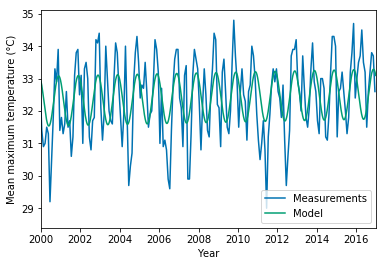

In [13]:
fig, ax = plt.subplots()

ax.plot(*dwtemp.T, label='Measurements')
ax.set_xlabel('Year')
ax.set_ylabel('Mean maximum temperature (°C)')

model_dates = np.linspace(2000, 2017, 1700)
t_hats = temperature(params_hat, model_dates)
ax.plot(model_dates, t_hats, label='Model')
ax.set_xlim(2000, 2017)

ax.legend(loc='lower right')


### Exercises

1. What is the average square deviation between the model and the average temperature?
2. Eyeballing it, it looks like the amplitude parameter could be increased to
   improve the accuracy of the model. Test that hypothesis by measuring the mean
   squared error (MSE) that you defined above for various changes to the amplitude.
3. Repeat the above exercise, but limiting the measurements to what we've plotted:
   from the year 2000 onwards.
4. *Bonus* Repeat the analysis for the Melbourne (Bundoora) temperature dataset, in
   `data/bundoora-temp.csv`. Is your MSE for the same model higher or lower?

## Interpolating data

Here we show how to interpolate between noisy data representing samples or
measurements over time.

In [ ]:
import seaborn as sns

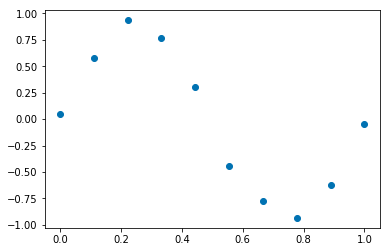

In [22]:
t = np.linspace(0, 1, 10)
noise = (np.random.random(10)*2 - 1) * 0.1
measured = np.sin(2 * np.pi * t) + noise
plt.plot(t, measured, 'o');

In [23]:
from scipy import interpolate

In [24]:
model_linear = interpolate.interp1d(t, measured, kind='linear')
model_cubic = interpolate.interp1d(t, measured, kind='cubic')

The model objects act like functions (they implement the ``__call__`` special
method). We can pass data to them to evaluate $y = f(x)$:

In [25]:
t2 = np.linspace(0, 1, 50)
y_linear = model_linear(t2)
y_cubic = model_cubic(t2)

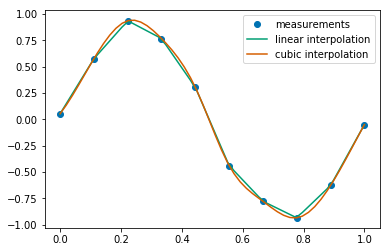

In [26]:
fig, ax = plt.subplots()

ax.plot(t, measured, marker='o', linewidth=0, label='measurements');
ax.plot(t2, y_linear, label='linear interpolation')
ax.plot(t2, y_cubic, label='cubic interpolation')
ax.legend();

### Exercises

- What is the expected high temperature on July 5th in Melbourne?

Use `data/melbourne-temp.csv` to compute the average high temperature for each
month from January 2000 (use `pandas`). Then, use these measurements and
interpolation to get the average temperature on July 5th.

In [27]:
meltemp_df = pd.read_csv('data/melbourne-temp.csv', header=0, na_values='null')

In [28]:
meltemp_monthly = meltemp_df[meltemp_df['Year'] > 2000].groupby('Month').mean()

In [29]:
months = meltemp_monthly.reset_index()[['Month', 'Mean maximum temperature (°C)']].values

Text(0,0.5,'Mean high temperature 2000-2016')

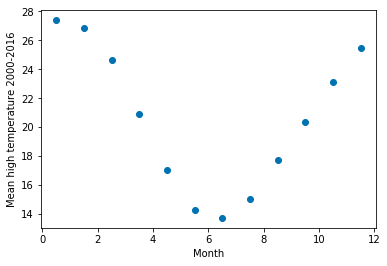

In [30]:
month = months[:, 0] - 0.5
high = months[:, 1]

fig, ax = plt.subplots()
ax.plot(month, high, marker='o', linestyle='')
ax.set_xlabel('Month')
ax.set_ylabel('Mean high temperature 2000-2016')

In [31]:
t_interp = interpolate.interp1d(month, high, kind='cubic')
t_interp(7 + 5/31)

array(14.411621509996374)

- What is the expected high temperature on Dec 31?

*Hint:* The data are periodic — how can you express this?

In [32]:
month_before = month - 12
month_after = month + 12
month_all = np.concatenate((month_before, month, month_after))
high_all = np.concatenate((high, high, high))

t_interp = interpolate.interp1d(month_all, high_all, kind='cubic')
t_interp(12)

array(26.600920822344506)

## n-d image interpolation

Here's a very simple image, a 2x2 pixel white square inside a 6x6 black
background:

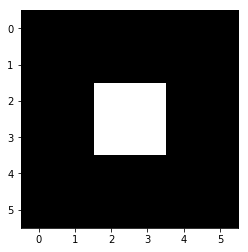

In [33]:
image = np.zeros((6, 6))
image[2:4, 2:4] =  1

fig, ax = plt.subplots()
ax.imshow(image)

What is the value at coordinate (1.5, 1.5), using cubic interpolation? To answer
this question, SciPy's `ndimage` package contains n-dimensional interpolation
using the `map_coordinates` function:

In [34]:
from scipy import ndimage as ndi

In [35]:
ndi.map_coordinates(image, ([1.5], [1.5]), order=3)

array([ 0.21707128])

The input format is a little bit tricky, but is consistent with NumPy's
indexing: we need a tuple of array-likes, each of the shape of the output array,
containing the first coordinate in the first array, the second coordinate in the
second array, and so on.

**Example:** Using `map_coordinates` to obtain a line profile across the centre
row (2.5) of the image:

Text(0,0.5,'Interpolated (cubic) value of image')

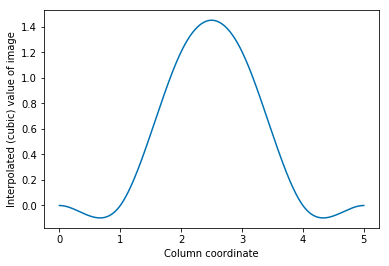

In [36]:
cols = np.linspace(0, 5, 500)
rows = np.full(cols.shape, 2.5)

values = ndi.map_coordinates(image, (rows, cols), order=3)

fig, ax = plt.subplots()
ax.plot(cols, values)
ax.set_xlabel('Column coordinate')
ax.set_ylabel('Interpolated (cubic) value of image')

### Exercises

- Use cubic interpolation with `map_coordinates` to find the 2-fold downsampled
  image of size 3x3 pixels.

*Hint:* First, figure out which coordinates you need to grab along each axis.
Then, look at the documentation for `np.mgrid`.

- In scikit-image and in some parts of matplotlib, by convention, images of the
  `float` dtype should have the range [0, 1]. What are the minimum and maximum
  values of your interpolated image? Use `np.clip` to obtain a "valid" image after
  interpolation. Plot the resulting line profile.

## Optimizing a function

Now we show how to find the parameter that minimizes a function that you define.

In [37]:
def f(x):
    return np.cos(x) * np.sin(x) * np.exp(x)

Text(0,0.5,'f(x)')

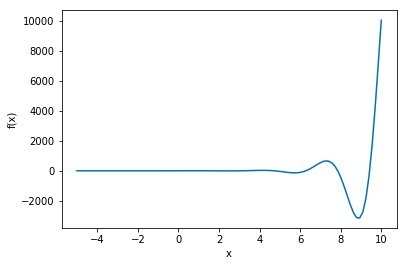

In [38]:
x = np.linspace(-5, 10, 100)
y = f(x)

fig, ax = plt.subplots()
ax.plot(x, y);
ax.set_xlabel('x')
ax.set_ylabel('f(x)')

There is a family of functions for optimization of functions in one or more
dimensions in ``scipy.optimize``. Here is a simple example:

In [39]:
from scipy import optimize
x_opt = optimize.fmin(f, x0=7.5)
x_opt

Optimization terminated successfully.
         Current function value: -3185.882612
         Iterations: 15
         Function evaluations: 30


array([ 8.8711853])

To maximize a function, minimize its negative.

### Exercises

Try the above optimization, but change the starting value to 4.5. What is the
result?

### Optimization for image alignment

Let's look again at the `astronaut` image from scikit-image:

In [40]:
from skimage import data

astronaut = data.astronaut()

We'll convert it to black and white to simplify the following:

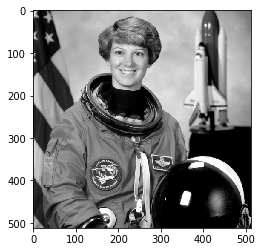

In [41]:
from skimage import color

astronaut = color.rgb2gray(astronaut)

fig, ax = plt.subplots()
ax.imshow(astronaut)

Suppose we have a shifted image:

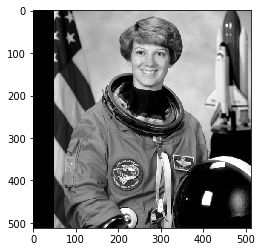

In [42]:
astronaut_shifted = ndi.shift(astronaut, (0, 50))

fig, ax = plt.subplots()
ax.imshow(astronaut_shifted)

Let's define a function that takes in a horizontal shift and an image, and
computes the difference between the shifted function and our original:

In [43]:
def astronaut_shift_error(hshift, image):
    corrected = ndi.shift(image, (0, hshift))
    overlap = (corrected * astronaut).astype(bool)
    return np.mean((astronaut[overlap] - corrected[overlap])**2)

Now we can use this function, in conjunction with fmin, to recover the original
alignment:

In [44]:
opt_shift = optimize.fmin(astronaut_shift_error, x0=0, args=(astronaut_shifted,))
opt_shift

Optimization terminated successfully.
         Current function value: 0.132597
         Iterations: 3
         Function evaluations: 7


array([ 0.00025])

Oops! That didn't do anything! Some functions are too jittery for the simple
optimisation procedure in `fmin`. The `minimize` function provides a class of
more powerful optimisation methods that can avoid *some* local minima:

In [45]:
opt_shift = optimize.minimize(astronaut_shift_error, x0=0, args=(astronaut_shifted,), method='Powell')

In [46]:
opt_shift

   direc: array([[ 0.09924379]])
     fun: 1.347117076816656e-29
 message: 'Optimization terminated successfully.'
    nfev: 68
     nit: 4
  status: 0
 success: True
       x: array(-49.99999999999995)

You can read more about the various optimisation methods in the documentation
for SciPy's optimize package.

### Exercises

- Use the `astronaut_shift_error` function to compute the shift error for various
  values of horizontal shift, say, from -480 to 380.

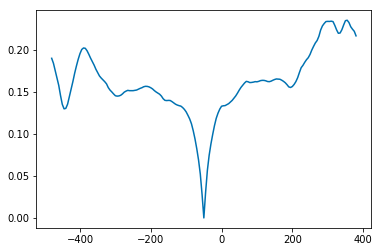

In [47]:
plt.plot(np.arange(-480, 381, 5), [astronaut_shift_error(s, astronaut_shifted) for s in np.arange(-480, 381, 5)])

- Identify local minima in the above plot, and use those to create a bad start
  value for `optimize.minimize`. Show that `optimize.minimize` doesn't converge to
  the correct value (-50) when that start value is used.

In [48]:
opt_shift = optimize.minimize(astronaut_shift_error, x0=250, args=(astronaut_shifted,), method='Powell')
opt_shift

   direc: array([[-50.54281]])
     fun: 0.154823389184361
 message: 'Optimization terminated successfully.'
    nfev: 66
     nit: 3
  status: 0
 success: True
       x: array(192.36834446624755)

- Try the function `optimize.basinhopping`. Does that now recover the correct
  shift? (Warning: this function is slow!)

*Hint:* Try increasing the `stepsize` to something reasonable when it comes to
pixel shifts.

In [ ]:
opt_shift = optimize.basinhopping(astronaut_shift_error, x0=250, stepsize=50,
                                  minimizer_kwargs={'args': (astronaut_shifted,),
                                                    'method': 'Powell'})

opt_shift

Note that OpenOpt offers a more comprehensive set of optimization routines than
SciPy. It includes solvers for discrete, constrained and mixed-integer
optimization problems such as bin-packing (for transport) and the "travelling salesman problem".
## Data smoothing / denoising

This section shows how to smooth data, using images as an example.

In [50]:
# Import the signal processing toolbox from SciPy:
from scipy import signal

We will show noisy data in 2 dimensions and apply mean and Gaussian filters:

In [51]:
X, Y = np.mgrid[-70:70, -70:70]
Z = np.cos((X**2+Y**2)/200.)+ np.random.normal(size=X.shape)

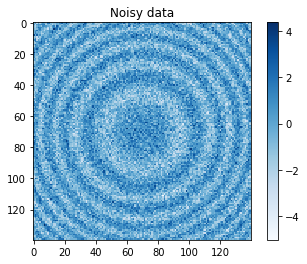

In [52]:
plt.figure()
plt.imshow(Z, cmap='Blues')
plt.colorbar()
plt.title('Noisy data');

In [53]:
def blur_image(im, kernel, n, mode='valid'):
    """
    Blurs the image by convolving with a kernel (e.g. mean or gaussian) of typical
    size n. The optional keyword argument ny allows for a different size in the
    y direction.
    """
    g = kernel(n)
    improc = signal.convolve(im, g, mode=mode)
    return(improc)

In [54]:
def mean_kern(size):
    """
    Returns a mean kernel for convolutions, with dimensions
    (2*size+1, 2*size+1).
    """
    kernel = np.ones((2*size+1, 2*size+1))
    return kernel / kernel.sum()

In [55]:
Z2 = blur_image(Z, mean_kern, 3)

In [56]:
def gauss_kern(size):
    """ Returns a normalized 2D gauss kernel array for convolutions """
    x, y = np.mgrid[-size:size+1, -size:size+1]
    g = np.exp(-(x**2/float(size) + y**2/float(size)))
    return g / g.sum()

In [57]:
Z3 = blur_image(Z, gauss_kern, 10)

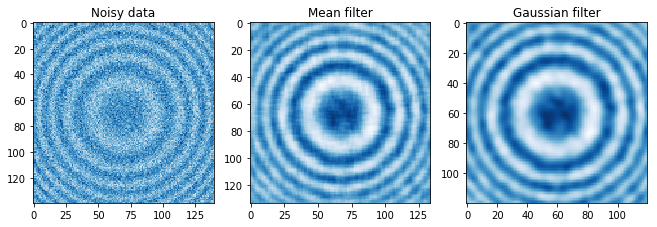

In [58]:
fig, axes = plt.subplots(1, 3, figsize=(11, 6))
axes[0].imshow(Z, cmap='Blues')
axes[0].set_title('Noisy data');
axes[1].imshow(Z2, cmap='Blues')
axes[1].set_title('Mean filter');
axes[2].imshow(Z3, cmap='Blues');
axes[2].set_title('Gaussian filter');

### Image reconstruction with a Wiener Filter

In [59]:
import seaborn as sns
sns.set_style('ticks')

In [60]:
from scipy import signal, misc, mean, std

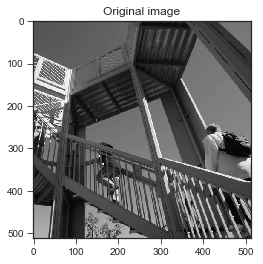

In [61]:
#Image sample is a classic image in signal processing.
original_image = misc.ascent()
plt.title('Original image')
plt.imshow(original_image, cmap='gray');

Image noise is Guassian distribution with mean $\mu=0$ and standard deviation
$\sigma=20$:

In [62]:
sigma = 20
noise = np.random.standard_normal(original_image.shape)

# Add noise to the image
noisy_image = original_image + sigma * noise

We will now perform image reconstruction using the Wiener filter from
``scipy.signal``. This is a simple local-mean filter. Noise power is estimated
as the average of the local variances.

In [63]:
from scipy.signal import wiener
denoised_image = wiener(noisy_image)

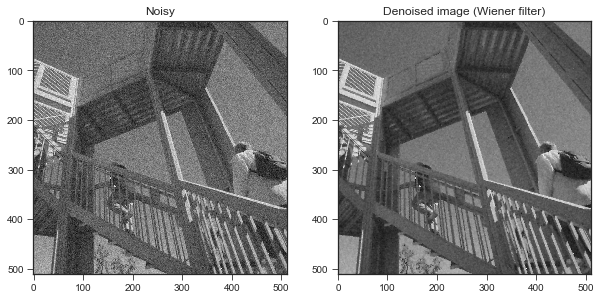

In [64]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
axes[0].set_title('Noisy')
axes[0].imshow(noisy_image, cmap='gray')
axes[1].set_title('Denoised image (Wiener filter)')
axes[1].imshow(denoised_image, cmap='gray');

In [65]:
%timeit signal.wiener(noisy_image)

84.2 ms ± 6.12 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Filtering in the frequency domain

This example is from Stefan van der Walt's tutorial at EuroSciPy 2011. We take a
signal and remove its periodic noise in the frequency domain.

In [66]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

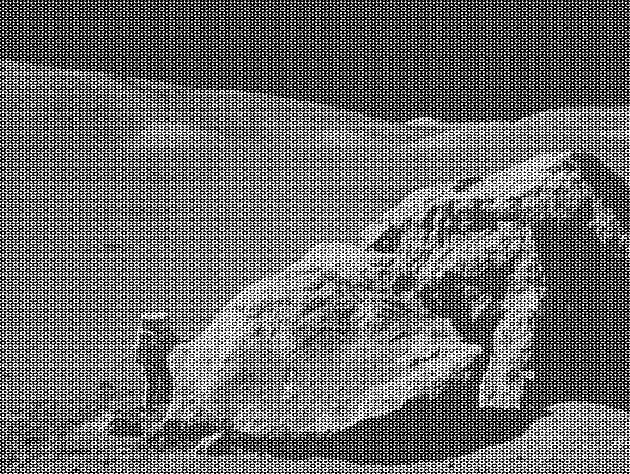

In [67]:
from IPython.core.display import Image
Image(filename='data/moonlanding.png')

This image has heavy periodic noise. We will filter it out in the frequency
domain and then reconstruct the image in the original domain.

In [68]:
def plot_spectrum(F, axis):
    axis.imshow(np.log(5 + np.abs(F)))

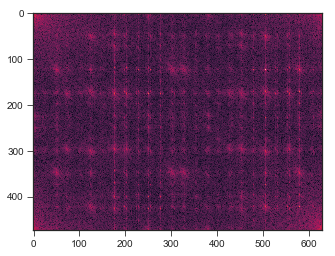

In [69]:
im = plt.imread(r'data/moonlanding.png').astype(float)

# Compute the 2d FFT of the input image
F = np.fft.fft2(im)

plot_spectrum(F, plt)

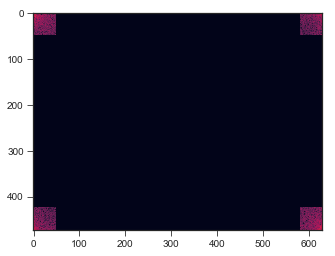

In [70]:
ff = F.copy()
ff[50:-50, :] = 0
ff[:, 50:-50] = 0
plot_spectrum(ff, plt)

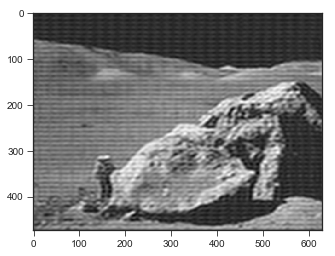

In [71]:
im_new = np.fft.ifft2(ff).real
plt.imshow(im_new, cmap='gray');

Show the results of everything together:

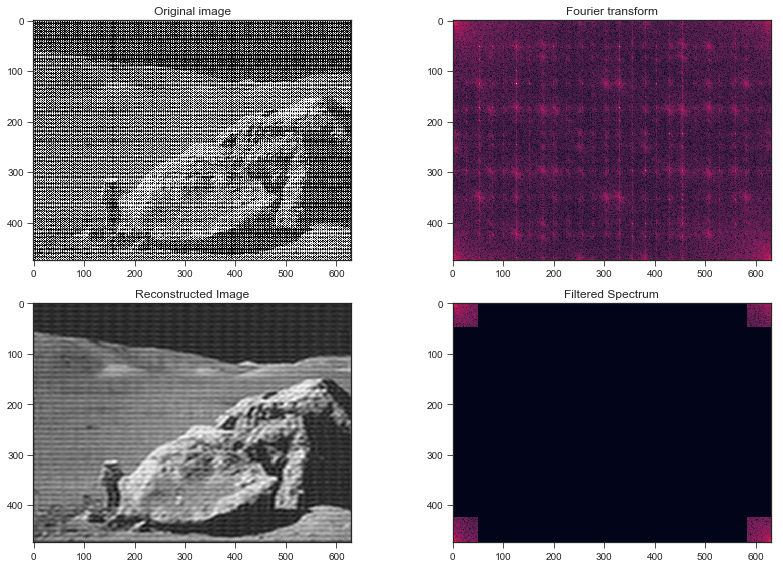

In [72]:
(fig, axes) = plt.subplots(2, 2, figsize=(12, 8))
axes[0, 0].set_title('Original image')
axes[0, 0].imshow(im, plt.cm.gray)

axes[0, 1].set_title('Fourier transform')
plot_spectrum(F, axes[0, 1])

axes[1, 1].set_title('Filtered Spectrum')
plot_spectrum(ff, axes[1, 1])

axes[1, 0].set_title('Reconstructed Image')
axes[1, 0].imshow(im_new, plt.cm.gray)

plt.tight_layout()   # better spacing

## Ordinary differential equations (ODEs)

ODEs are useful in many subfields of engineering, science, finance and
elsewhere. Parts of this section are derived from J.R. Johansson's SciPy lecture
notes: http://github.com/jrjohansson/scientific-python-lectures. Licence:
Creative Commons Attribution 3.0.

SciPy provides an ``odeint`` function and an ``ode`` class in the
``scipy.integrate`` module. The ``odeint`` function is simpler to use, whereas
the object-oriented ``ode`` class offers more control.

In [73]:
from scipy.integrate import odeint, ode

### Formulation

We write:

$y' = f(y, t)$

where

$y = [y_1(t), y_2(t), ..., y_n(t)]$

and $f$ is some function that gives the derivatives of the function $y_i(t)$. To
solve this we need to know the function $f$ and an initial condition $y(0)$.

After we define the Python function ``f`` and array ``y_0``, we can use the
``odeint`` function as::

In [ ]:
y_t = odeint(f, y_0, t)

where ``t`` is an array of time-coordinates for which to solve the ODE problem.
``y_t`` is an array with one row for each point in time in ``t``, where each
column corresponds to a solution $y_i(t)$ at that point in time.

### Example 1: $dy/dt = -2y$

We'll solve this between 0 and 4, with initial condition $y(0) = 1$.

In [75]:
def f(y, t):
    return -2*y
y_0 = 1

In [76]:
# To get help on calling odeint, use:
#     odeint?
# in IPython.

In [77]:
# Solve it from t=0 to t=4, with 50 points
t = np.linspace(0, 4, 50)
y = odeint(f, y_0, t)

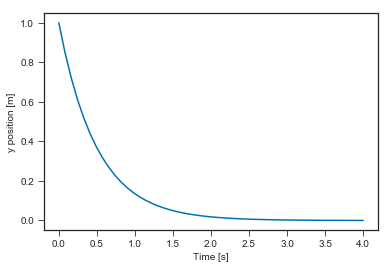

In [78]:
plt.plot(t, y)
plt.xlabel('Time [s]')
plt.ylabel('y position [m]');

### Example: damped harmonic oscillator

This is a second-order ODE (see http://en.wikipedia.org/wiki/Damping). In
standard form, the equation of motion for the damped oscillator is:

$\frac{dp}{dt} = -2\zeta \omega_0 p - \omega_0^2 x$, where $\frac{dx}{dt} = p$.

In [79]:
def dy(y, t, zeta, w0):
    'The RHS of the damped oscillator ODE'
    x, p = y[0], y[1]
    dx = p
    dp = -2 * zeta * w0 * p - w0**2 * x
    return dx, dp

In [80]:
# initial condition
y0 = [1.0, 0.0]

In [81]:
# time coord to solve the ODE for:
t = np.linspace(0, 10, 1000)
w0 = 2*np.pi*1.0

In [82]:
# dy(y0, t, 0.0, w0)

In [83]:
# Solve the ODE problem for four different values of the damping ratio

y1 = odeint(dy, y0, t, args=(0.0, w0)) # undamped
y2 = odeint(dy, y0, t, args=(0.2, w0)) # under damped
y3 = odeint(dy, y0, t, args=(1.0, w0)) # critial damping
y4 = odeint(dy, y0, t, args=(5.0, w0)) # over damped

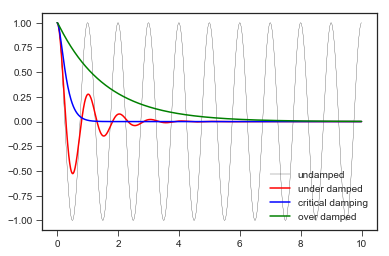

In [84]:
fig, ax = plt.subplots()
ax.plot(t, y1[:,0], 'k', label="undamped", linewidth=0.25)
ax.plot(t, y2[:,0], 'r', label="under damped")
ax.plot(t, y3[:,0], 'b', label=r"critical damping")
ax.plot(t, y4[:,0], 'g', label="over damped")
ax.legend();

### Plotting ODE solutions in cylindrical coordinates

Example is from John Kitchin's book, "Python Computations in Science and
Engineering": https://github.com/jkitchin/pycse

Here we will solve an ODE in cylindrical coordinates, then convert the solution
to Cartesian coordinates to plot it.

In [85]:
def df_dt(F, t):
    rho, theta, z = F
    d_rho_dt = 0   # constant radius
    d_theta_dt = 1 # constant angular velocity
    dz_dt = -1     # constant dropping velocity
    return [d_rho_dt, d_theta_dt, dz_dt]

In [86]:
# Initial conditions:
(rho0, theta0, z0) = (1, 0, 100)

In [87]:
# Solve
t = np.linspace(0, 50, 500)
sol = odeint(df_dt, [rho0, theta0, z0], t)
rho, theta, z = sol.T

In [88]:
# Convert cylindrical coords to Cartesian for plotting
X = rho * np.cos(theta)
Y = rho * np.sin(theta)

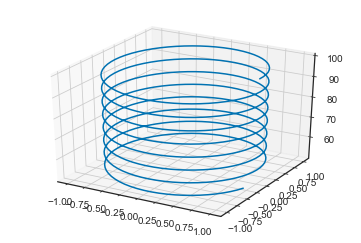

In [89]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(X, Y, z);

### Multibody dynamics in Python

There is an interesting article by Jason Keith Moore here on complex dynamics
and control problems in Python using SciPy, SymPy, and python-control.

The example there is of balancing an n-link pendulum.
http://www.moorepants.info/blog/npendulum.html. Licence: public domain.

In [90]:
from IPython.display import SVG
SVG(url='https://raw.github.com/PythonDynamics/pydy_examples/master/npendulum/n-pendulum-with-cart.svg')

<IPython.core.display.SVG object>

### ODEs: other links

Python Dynamics:
- https://github.com/PythonDynamics/pydy-viz
- https://github.com/PythonDynamics/scipy-2013-mechanics
- http://www.pydy.org/examples

Sympy mechanics:
- http://docs.sympy.org/dev/modules/physics/mechanics/index.html

There is also a comprehensive chapter on Ordinary Differential Equations in the
book by John Kitchin mentioned above: "Python Computations in Science and
Engineering": https://github.com/jkitchin/pycse.